In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import shutil
from PIL import Image

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.19.5
TensorFlow Version :2.4.1
Matplotlib Version :3.2.2


In [ ]:

colab=True
try:
  from google.colab import drive
except:
  colab =False
if colab : 
    drive.mount('/content/drive')
    print('g-drive mounted.')
else : print('local drive.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
g-drive mounted.


#  저장파일 경로 반드시 확인!!!!!!

In [ ]:
save_dir = '/content/drive/MyDrive/SCSA_Project/save/Ver3/'

In [ ]:
x_path = "/content/drive/MyDrive/SCSA_Project/files/final_input.npy"
y_path = "/content/drive/MyDrive/SCSA_Project/files/final_labels.npy"

imgs = np.load(x_path)
labels = np.load(y_path)

In [ ]:
print(imgs.shape)
print(labels.shape)

(2800, 120, 160, 3)
(2800, 1)


## 데이터 확인

label crowd : [3]


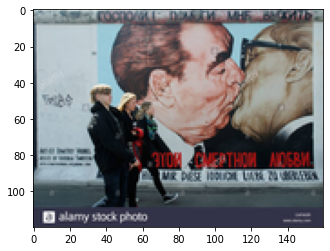

In [ ]:
plt.imshow(imgs[0])
print("label crowd : " + str(labels[0]))

label crowd : [3]


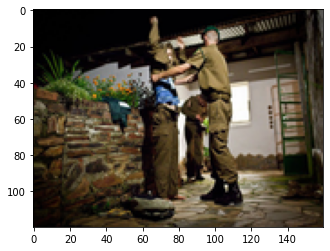

In [ ]:
plt.imshow(imgs[50])
print("label crowd : " + str(labels[50]))

label crowd : [4]


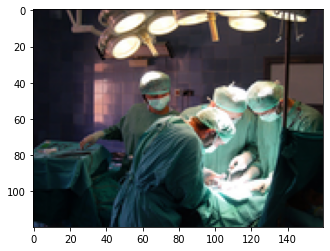

In [ ]:
plt.imshow(imgs[100])
print("label crowd : " + str(labels[100]))

label crowd : [8]


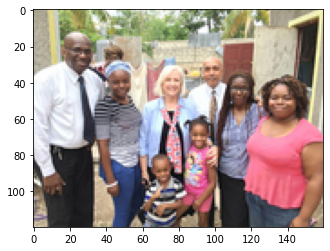

In [ ]:
plt.imshow(imgs[500])
print("label crowd : " + str(labels[500]))

## 모델 설정 및 학습

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, shuffle = True)

In [ ]:
def create_model():

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, (3,3), input_shape=(imgs.shape[1], imgs.shape[2], 3), activation=tf.keras.activations.relu),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
      tf.keras.layers.Dense(1)
  ])
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

  return model

model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 118, 158, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 79, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 57, 77, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 38, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 38, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 136192)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [ ]:
checkpoint_path = save_dir + "log/cp-{epoch:04d}.ckpt"

In [ ]:
lr_monitor = tf.keras.callbacks.LearningRateScheduler(
                lambda epochs : 1e-8 * 10 ** (epochs/20))

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
%%time
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=80, batch_size=16, shuffle = True, callbacks=[lr_monitor, cp_callback])

Epoch 1/80
140/140 [==============================] - 3s 22ms/step - loss: 28.5506 - mae: 29.0484 - val_loss: 17.4737 - val_mae: 17.9683

Epoch 00001: saving model to /content/drive/MyDrive/SCSA_Project/save/Ver3/log/cp-0001.ckpt
Epoch 2/80
140/140 [==============================] - 3s 21ms/step - loss: 19.4626 - mae: 19.9583 - val_loss: 11.1897 - val_mae: 11.6813

Epoch 00002: saving model to /content/drive/MyDrive/SCSA_Project/save/Ver3/log/cp-0002.ckpt
Epoch 3/80
140/140 [==============================] - 3s 21ms/step - loss: 15.1241 - mae: 15.6179 - val_loss: 9.6940 - val_mae: 10.1857

Epoch 00003: saving model to /content/drive/MyDrive/SCSA_Project/save/Ver3/log/cp-0003.ckpt
Epoch 4/80
140/140 [==============================] - 3s 21ms/step - loss: 13.5384 - mae: 14.0331 - val_loss: 9.6016 - val_mae: 10.0900

Epoch 00004: saving model to /content/drive/MyDrive/SCSA_Project/save/Ver3/log/cp-0004.ckpt
Epoch 5/80
140/140 [==============================] - 3s 21ms/step - loss: 14.0288

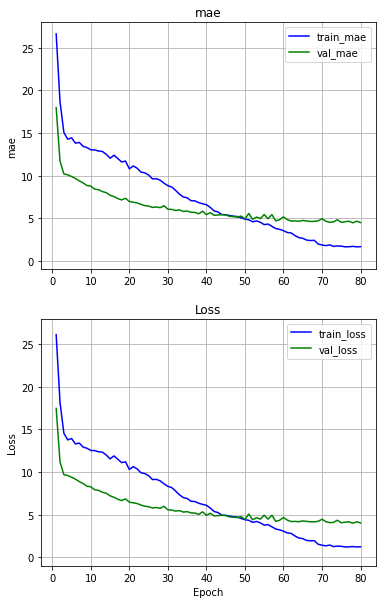

In [ ]:
loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(6, 10))
plt.subplot(2, 1, 1)
plt.title('mae')
plt.ylim([int(min(history.history['mae']+history.history['val_mae'])) - 2, int(max(history.history['mae']+history.history['val_mae'])) + 2])
plt.plot(epochs, history.history['mae'], 'b', label='train_mae')
plt.plot(epochs, history.history['val_mae'], 'g', label='val_mae')
plt.grid(True)
plt.ylabel('mae')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.ylim([int(min(history.history['loss']+history.history['val_loss'])) - 2, int(max(history.history['loss']+history.history['val_loss'])) + 2]) 
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

print()

## 모델 검증

In [ ]:
model_json = model.to_json()
with open(save_dir + "final_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save(save_dir + 'final_model.h5')

label crowd : [11]
predict crowd : [16.189127]


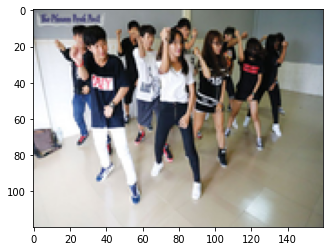

In [ ]:
from PIL import Image, ImageFile
from IPython.display import display
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model


plt.imshow(imgs[880])
print("label crowd : "+ str(labels[880]))
picture = imgs[880]
picture = picture[np.newaxis,:]

model = load_model(save_dir + 'final_model.h5')
result = model.predict(picture)
print("predict crowd : " + str(*result))

label crowd : [6]
predict crowd : [11.293218]


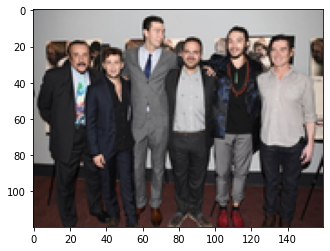

In [ ]:
plt.imshow(imgs[333])
print("label crowd : "+ str(labels[333]))
picture = imgs[333]
picture = picture[np.newaxis,:]

model = load_model(save_dir + 'final_model.h5')
result = model.predict(picture)
print("predict crowd : " + str(*result))

label crowd : [8]
predict crowd : [17.6218]


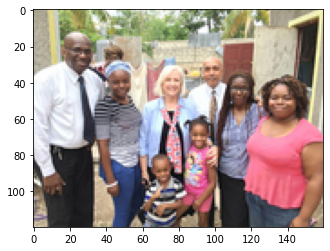

In [ ]:
plt.imshow(imgs[500])
print("label crowd : "+ str(labels[500]))
picture = imgs[500]
picture = picture[np.newaxis,:]

model = load_model(save_dir + 'final_model.h5')
result = model.predict(picture)
print("predict crowd : " + str(*result))

label crowd : [22]
predict crowd : [21.074966]


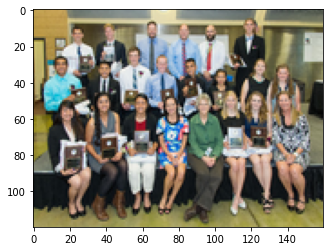

In [ ]:
num = 1901

plt.imshow(imgs[num])
print("label crowd : "+ str(labels[num]))
picture = imgs[num]
picture = picture[np.newaxis,:]

model = load_model(save_dir + 'final_model.h5')
result = model.predict(picture)
print("predict crowd : " + str(*result))